In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [2]:
import os

print(os.listdir(path+"/Data/images_original"))

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [127]:
def train_model(num_epochs, model, optimizer, train_loader, val_loader, patience=5):
    """
    Function for training and validating a model.
    It trains the model for a given number of epochs, calculates the loss and accuracy
    for both training and validation sets, and prints results after each epoch.

    Args:
        num_epochs (int): number of epochs to train
        model (torch.nn.Module): model that needs to be trained
        optimizer (torch.optim.Optimizer): optimization algorithm (like Adam or RMSprop)
        train_loader (DataLoader): loader with training data
        val_loader (DataLoader): loader with validation data
    """

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):

        # ===== TRAINING PHASE =====
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs.contiguous()                            # ensure inputs are stored continuously in memory
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()                          # set all gradients to zero before backpropagation

            outputs = model(inputs)                        # forward pass: get predictions
            loss = model_loss(outputs, labels)             # calculate how wrong the predictions are

            loss.backward()                                # backward pass: compute gradients
            optimizer.step()                               # update model parameters

            running_loss += loss.item()                    # add loss value for statistics
            _, predicted = torch.max(outputs, 1)           # get predicted class
            total += labels.size(0)                        # total number of samples seen

        # ===== VALIDATION PHASE =====
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():                              # no gradients needed for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = model_loss(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = correct / total
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_loss: {avg_val_loss:.4f}, Val_acc: {val_acc:.4f}')

        # EARLY STOPPING
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0  # reset counter if validation loss improves
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def test_model(model, test_loader, audio_dataset):
    """
    Evaluates a trained model on a test dataset, computes the loss and accuracy, 
    and visualizes the performance using a confusion matrix.

    Args:
        model (torch.nn.Module): The trained neural network model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader providing the test dataset batches.
        audio_dataset (AudioDataset): Instance of the dataset containing label mappings 
                                      for displaying class names in the confusion matrix.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_preds = []   # Stores all predicted labels
    all_labels = []  # Stores all true labels

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)               # Forward pass
            loss = model_loss(outputs, labels)    # Compute the loss

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)   # Get the class with the highest score
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU and save
            all_labels.extend(labels.cpu().numpy())    # Move labels to CPU and save

    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

    
    # ======= PLOT CONFUSION MATRIX =======
    
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(audio_dataset.label_mapping.keys()))
    disp.plot(cmap=plt.cm.Purples, ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Data preparation

In [121]:
import torch
import torchaudio
from torch.utils.data import Dataset
import os

class AudioDataset(Dataset):
    """
    AudioDataset is a custom Dataset class for loading and processing audio data for machine learning tasks.
    
    This class reads .wav files organized into subfolders (where each folder corresponds to a label, like a genre),
    applies optional preprocessing steps such as resampling, silence removal, and feature extraction (MFCC),
    and splits the audio files into fixed-size chunks to be used for training.
    
    Args:
        root_dir (str): Root directory containing subfolders of audio files for each class.
        num_samples (int, optional): Number of samples per audio chunk. Default is 22050.
        target_sample_rate (int, optional): Target sample rate for audio. Audio will be resampled if needed. Default is 22050.
        use_mfcc (bool, optional): Whether to extract MFCC features from audio chunks. Default is False.
        trans (bool, optional): Whether to transpose waveform dimensions after loading. Useful for feeding into certain models. Default is True.
        silence (bool, optional): Whether to remove silence from audio before splitting into chunks. Default is True.
    
    Attributes:
        audio_paths (list): List of paths to all loaded audio files.
        labels (list): Corresponding labels for each audio file.
        label_mapping (dict): Mapping from genre (folder name) to integer label.
        chunks (list): List of processed audio chunks paired with their labels.
    
    Methods:
        calculate_threshold(waveform, factor=0.3):
            Calculates a silence threshold based on the mean absolute amplitude of the waveform.
    
        remove_silence(waveform, threshold):
            Removes sections of the waveform where the amplitude is below the threshold.
    
        prepare_chunks():
            Processes all audio files: loading, optional resampling, silence removal,
            optional MFCC extraction, and splitting into chunks.
    
        get_label_name(label_id):
            Returns the genre name (folder name) given a label index.
    
        __len__():
            Returns the total number of chunks in the dataset.
    
        __getitem__(idx):
            Returns the feature chunk and corresponding label at the given index.
    """

    def __init__(self, root_dir, num_samples=22050, target_sample_rate=22050, use_mfcc=False, trans=True, silence=True):
        self.root_dir = root_dir
        self.num_samples = num_samples
        self.target_sample_rate = target_sample_rate
        self.use_mfcc = use_mfcc  # Whether to use MFCC features
        self.trans = trans  # Whether to transpose waveform dimensions
        self.silence = silence  # Whether to remove silence
        
        self.audio_paths = []
        self.labels = []
        self.label_mapping = {}
        
        genres = sorted(os.listdir(root_dir))  # Folders correspond to different genres
        for idx, genre in enumerate(genres):
            self.label_mapping[genre] = idx
            genre_dir = os.path.join(root_dir, genre)
            for file_name in os.listdir(genre_dir):
                if file_name.endswith(".wav"):
                    self.audio_paths.append(os.path.join(genre_dir, file_name))
                    self.labels.append(idx)
        
        # If MFCCs are selected, prepare the MFCC transform
        if self.use_mfcc:
            self.mfcc_transform = torchaudio.transforms.MFCC(
                sample_rate=self.target_sample_rate,
                n_mfcc=40,
                melkwargs={"n_fft": 900, "hop_length": 160, "n_mels": 40}
            )
        
        self.chunks = []
        self.prepare_chunks()

    def calculate_threshold(self, waveform, factor=0.3):
        # Calculate a threshold for silence based on the average amplitude
        return waveform.abs().mean() * factor
    
    def remove_silence(self, waveform, threshold):
        # Remove parts of the waveform where the amplitude is below the threshold
        mask = waveform.abs() > threshold
        return waveform[:, mask.squeeze()].contiguous()
        
    def prepare_chunks(self):
        # Prepare fixed-length chunks from all audio files
        for path, label in zip(self.audio_paths, self.labels):
            try:
                waveform, sample_rate = torchaudio.load(path)
            except Exception as e:
                print(f"Failed to load file {path}: {e}")
                continue  # Skip broken files
            
            # Resample if needed
            if sample_rate != self.target_sample_rate:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
                waveform = resampler(waveform)

            if self.silence:
                threshold = self.calculate_threshold(waveform)
                waveform = self.remove_silence(waveform, threshold)
            
            total_samples = waveform.shape[1]
            num_chunks = total_samples // self.num_samples  # Number of full chunks
            
            for i in range(num_chunks):
                start = i * self.num_samples
                end = start + self.num_samples
                chunk = waveform[:, start:end]
                
                # If using MFCC, apply the transform here
                if self.use_mfcc:
                    mfcc = self.mfcc_transform(chunk)
                    mfcc = mfcc.squeeze(0).transpose(0, 1).contiguous()  # [time_steps, n_mfcc]
                    self.chunks.append((mfcc, label))
                else:
                    if self.trans:
                        chunk = chunk.transpose(0, 1).contiguous()
                    self.chunks.append((chunk, label))

    def get_label_name(self, label_id):
        # Get the genre name from the label id
        inv_mapping = {v: k for k, v in self.label_mapping.items()}
        return inv_mapping[label_id]
    
    def __len__(self):
        # Return the number of chunks
        return len(self.chunks)
    
    def __getitem__(self, idx):
        # Return one chunk and its label
        features, label = self.chunks[idx]
        return features, label


In [122]:
audio_dataset = AudioDataset(root_dir=path+"/Data/genres_original", use_mfcc=True)

Не вдалося завантажити файл /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7fe84426e446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7fe8442186e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7fe84406b134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const

In [123]:
audio_dataset[0][0].shape

torch.Size([138, 40])

In [124]:
from torch.utils.data import DataLoader, random_split

# split on train, test, and validation subsets
total_size = len(audio_dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.2 * total_size)
test_size  = total_size - train_size - val_size   # overall sum must equal total_size

audio_train, audio_val, audio_test = random_split(
    audio_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(666)  # for the same result regardless of experiments
)

print(f"Dataset: {len(audio_dataset)}, Train: {len(audio_train)}, Val: {len(audio_val)}, Test: {len(audio_test)}")

# Dataset: 1647, Train: 1152, Val: 329, Test: 166

Dataset: 22285, Train: 15599, Val: 4457, Test: 2229


In [129]:
from torch.utils.data import DataLoader

# tranform data to batches
audio_train_loader = DataLoader(audio_train, batch_size=64, shuffle=True, drop_last=True)
audio_val_loader   = DataLoader(audio_val, batch_size=64, drop_last=True)
audio_test_loader  = DataLoader(audio_test, batch_size=64, drop_last=True)

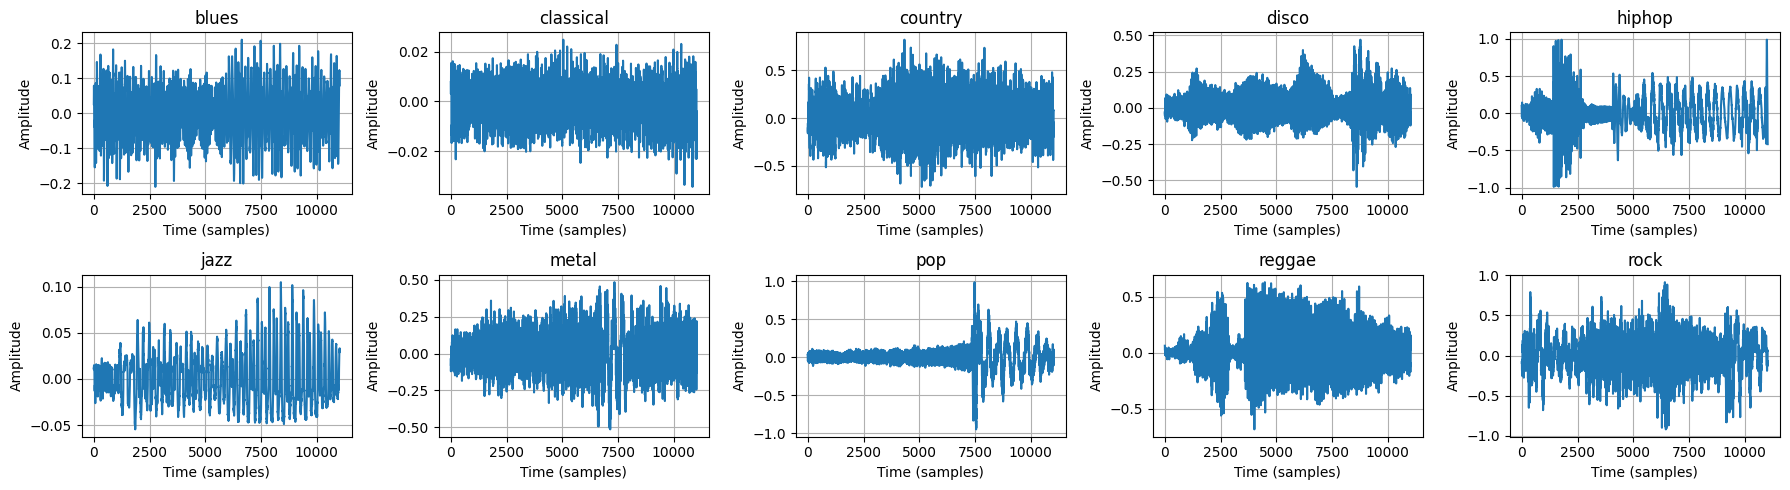

In [31]:
import matplotlib.pyplot as plt

class_names = list(audio_dataset.label_mapping.keys())

def get_label_name(label_id):
    inv_mapping = {v: k for k, v in audio_dataset.label_mapping.items()}
    return inv_mapping[label_id]

shown = set()

plt.figure(figsize=(18, 5))
i = 0

for waveform, label in audio_dataset:
    if label not in shown:
        waveform = waveform.squeeze().numpy()
        plt.subplot(2, 5, i + 1)
        plt.plot(waveform)
        plt.title(get_label_name(label))
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        shown.add(label)
        i += 1
    if len(shown) == len(class_names):
        break

plt.tight_layout()
plt.show()

# Net5

In [108]:
import torch.nn as nn

class Net5(nn.Module):
    """
    Net5 is a neural network model based on a two-layer LSTM architecture followed by fully connected layers.

    This model is designed for sequence data where each input sample is a sequence of feature vectors. 
    After passing through two LSTM layers, 
    the last output of the sequence is taken and processed by a series of fully connected layers with ReLU activations
    to produce final class logits.

    Args:
        input_size (int, optional): Number of input features per timestep. Default is 40.
        num_classes (int, optional): Number of output classes for classification. Default is 10.

    Attributes:
        lstm1 (nn.LSTM): First LSTM layer transforming input to hidden state of size 512.
        lstm2 (nn.LSTM): Second LSTM layer transforming hidden state from 512 to 256.
        fc1 (nn.Linear): Fully connected layer reducing from 256 to 128 dimensions.
        fc2 (nn.Linear): Fully connected layer reducing from 128 to 64 dimensions.
        fc3 (nn.Linear): Final fully connected layer producing num_classes outputs.
        relu (nn.ReLU): ReLU activation function.

    Methods:
        forward(x):
            Defines the forward pass of the model. Processes input through LSTM layers,
            selects the last timestep output, applies fully connected layers with ReLU activations,
            and returns the final output logits.
    """
    def __init__(self, input_size=40, num_classes=10):
        super().__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=512, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = x[:, -1, :]  # Take the output from the last timestep

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [130]:
import torch.optim as optim
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# torch.backends.cudnn.enabled = False
torch.cuda.empty_cache()

model_5 = Net5().to(device)
model_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_5.parameters(), lr=0.0001)

print("\nTRAINING FOR 5 EPOCHS\n")
train_model(100, model_5, optimizer, audio_train_loader, audio_val_loader)


TRAINING FOR 5 EPOCHS

Epoch 1/100, Loss: 1.8865, Accuracy: 0.3429, Val_loss: 1.5545, Val_acc: 0.4549
Epoch 2/100, Loss: 1.4613, Accuracy: 0.4837, Val_loss: 1.4189, Val_acc: 0.5027
Epoch 3/100, Loss: 1.3393, Accuracy: 0.5222, Val_loss: 1.3280, Val_acc: 0.5297
Epoch 4/100, Loss: 1.2659, Accuracy: 0.5424, Val_loss: 1.3586, Val_acc: 0.5199
Epoch 5/100, Loss: 1.2068, Accuracy: 0.5637, Val_loss: 1.2363, Val_acc: 0.5607
Epoch 6/100, Loss: 1.1227, Accuracy: 0.6013, Val_loss: 1.2084, Val_acc: 0.5833
Epoch 7/100, Loss: 1.0638, Accuracy: 0.6191, Val_loss: 1.1370, Val_acc: 0.5976
Epoch 8/100, Loss: 0.9861, Accuracy: 0.6521, Val_loss: 1.1100, Val_acc: 0.6162
Epoch 9/100, Loss: 0.9550, Accuracy: 0.6632, Val_loss: 1.0576, Val_acc: 0.6365
Epoch 10/100, Loss: 0.8708, Accuracy: 0.6906, Val_loss: 0.9801, Val_acc: 0.6716
Epoch 11/100, Loss: 0.8030, Accuracy: 0.7208, Val_loss: 0.9748, Val_acc: 0.6667
Epoch 12/100, Loss: 0.7369, Accuracy: 0.7441, Val_loss: 0.9332, Val_acc: 0.6780
Epoch 13/100, Loss: 0.685

Result of Net5:
Test_loss: 0.7645680168095756, Test_accuracy: 0.7954963235294118


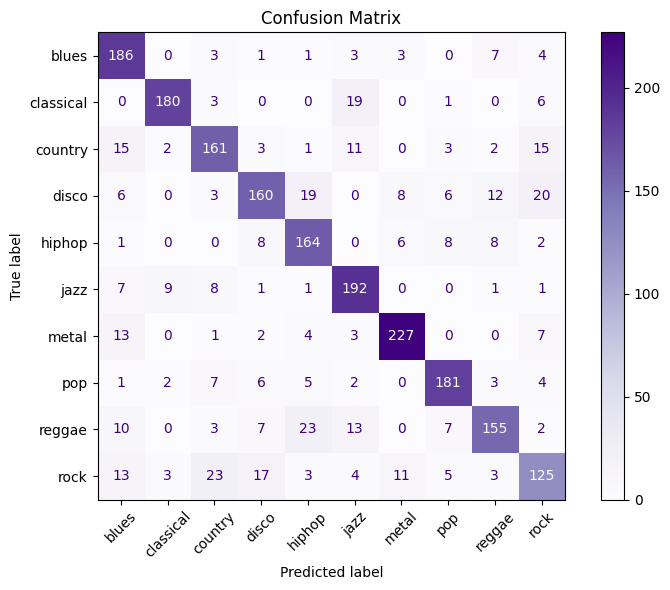

In [135]:
print("Result of Net5:")
test_model(model_5, audio_test_loader, audio_dataset)

# Net6

In [57]:
import torch
from torch.utils.data import DataLoader, Dataset

full_dataset = AudioDataset(root_dir=path + "/Data/genres_original", num_samples=16384, use_mfcc=False, trans=False, silence=False)

# Collect all waveforms into a dictionary, grouped by genre labels
genre_data = {}

for waveform, label in full_dataset:
    if label not in genre_data:
        genre_data[label] = []
    genre_data[label].append(waveform)

# Define a small dataset class to handle waveforms of a single genre
class GenreDataset(Dataset):
    def __init__(self, waveforms):
        self.waveforms = waveforms

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        return self.waveforms[idx]  # Only the waveform, no label

# Create separate DataLoaders for each genre
genre_loaders = {}

batch_size = 32

for label, waveforms in genre_data.items():
    dataset = GenreDataset(waveforms)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    genre_loaders[label] = loader


Не вдалося завантажити файл /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7fe84426e446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7fe8442186e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7fe84406b134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const

In [58]:
len(genre_loaders[2])

125

In [40]:
import torch
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, out_channels=1):
        super(Generator, self).__init__()
        
        # Projecting the input (latent vector) into a space (256 channels × 16 steps)
        self.project = nn.Sequential(
            nn.Linear(z_dim, 256 * 16),
            nn.ReLU()
        )
        
        # Transforming the projected input into the desired output shape
        self.gen = nn.Sequential(
            # Input shape: (batch_size, 256, 16)
            nn.ConvTranspose1d(256, 128, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(),
            # After this layer: (batch_size, 128, 64)
            
            nn.ConvTranspose1d(128, 64, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(),
            # After this layer: (batch_size, 64, 256)
            
            nn.ConvTranspose1d(64, 32, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(),
            # After this layer: (batch_size, 32, 1024)
            
            nn.ConvTranspose1d(32, 16, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(),
            # After this layer: (batch_size, 16, 4096)
            
            nn.ConvTranspose1d(16, out_channels, kernel_size=25, stride=4, padding=11, output_padding=1),
            # After this layer: (batch_size, 1, 16384)
            
            nn.Tanh()  # Output activation function
            # After this layer: (batch_size, 1, 65536)
        )
        
    def forward(self, z):
        out = self.project(z)                # (batch_size, 256*16)
        out = out.view(z.size(0), 256, 16)    # Reshaping to: (batch_size, 256, 16)
        out = self.gen(out)                   # Generating output: (batch_size, 1, 65536)
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            # Input shape: (batch_size, 1, 65536)
            nn.Conv1d(in_channels, 16, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2),
            # After this layer: (batch_size, 16, 16384)
            
            nn.Conv1d(16, 32, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2),
            # After this layer: (batch_size, 32, 4096)
            
            nn.Conv1d(32, 64, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2),
            # After this layer: (batch_size, 64, 1024)
            
            nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2),
            # After this layer: (batch_size, 128, 256)
            
            nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2),
            # After this layer: (batch_size, 256, 64)
        )
        
        self.fc = nn.Linear(256 * 16, 1)  # Flattening output for final classification

    def forward(self, x):
        out = self.disc(x)                   # (batch_size, 256, 64)
        out = out.view(x.size(0), -1)        # Flattening to: (batch_size, 256*16)
        out = self.fc(out)                   # Final output: (batch_size, 1)
        return out


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_genres = 10        # Number of genres in the dataset
noise_dim = 100        # Latent vector (z) dimension
lr = 1e-4              # Learning rate
num_epochs = 50        # Number of training epochs

# Create one generator and one discriminator for each genre
generators = [Generator(z_dim=noise_dim).to(device) for _ in range(num_genres)]
discriminators = [Discriminator().to(device) for _ in range(num_genres)]

# Create separate optimizers for each generator and discriminator
g_optimizers = [optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.9)) for g in generators]
d_optimizers = [optim.Adam(d.parameters(), lr=lr, betas=(0.5, 0.9)) for d in discriminators]

# Loss function for both the generator and discriminator
criterion = nn.BCEWithLogitsLoss()

# Training loop for each genre
for genre_idx in range(num_genres):
    print(f"--- Навчання для жанру {genre_idx} ---")
    G = generators[genre_idx]                       # Generator for the current genre
    D = discriminators[genre_idx]                   # Discriminator for the current genre
    g_optimizer = g_optimizers[genre_idx]           # Optimizer for the generator
    d_optimizer = d_optimizers[genre_idx]           # Optimizer for the discriminator
    loader = genre_loaders[genre_idx]               # DataLoader for the current genre

    for epoch in range(num_epochs):
        for real_data in loader:
            real_data = real_data.to(device)

            # === Train the discriminator ===
            batch_size = real_data.size(0)                       # Get the batch size
            real_labels = torch.ones(batch_size, 1).to(device)   # Labels for real data (1)
            fake_labels = torch.zeros(batch_size, 1).to(device)  # Labels for fake data (0)

            # Compute loss for real data
            d_real_loss = criterion(D(real_data), real_labels)

            # Generate fake data
            z = torch.randn(batch_size, noise_dim).to(device)  # Latent vector (z) sampled from a normal distribution
            fake_data = G(z)                                   # Fake data generated by the generator

            # Compute loss for fake data
            d_fake_loss = criterion(D(fake_data.detach()), fake_labels)

            # Total discriminator loss is the sum of the real and fake data losses
            d_loss = d_real_loss + d_fake_loss

            # Backpropagate and update the discriminator's weights
            d_optimizer.zero_grad()                            # Zero out previous gradients
            d_loss.backward()                                  # Compute gradients
            d_optimizer.step()                                 # Update the discriminator's weights

            # === Train the generator ===
            z = torch.randn(batch_size, noise_dim).to(device)  # Sample new latent vector
            fake_data = G(z)                                   # Generate fake data

            # The generator tries to fool the discriminator by using real labels for the fake data
            g_loss = criterion(D(fake_data), real_labels)      # Generator loss (try to make fake data real)

            # Backpropagate and update the generator's weights
            g_optimizer.zero_grad()                            # Zero out previous gradients
            g_loss.backward()                                  # Compute gradients
            g_optimizer.step()                                 # Update the generator's weights

        # Print the loss for each genre and epoch
        print(f"Жанр {genre_idx} | Епоха [{epoch+1}/{num_epochs}] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")


--- Навчання для жанру 0 ---
Жанр 0 | Епоха [1/50] | D_loss: 1.2787 | G_loss: 1.1784
Жанр 0 | Епоха [2/50] | D_loss: 1.2275 | G_loss: 3.3802
Жанр 0 | Епоха [3/50] | D_loss: 0.2989 | G_loss: 2.5506
Жанр 0 | Епоха [4/50] | D_loss: 0.7049 | G_loss: 2.1565
Жанр 0 | Епоха [5/50] | D_loss: 0.5507 | G_loss: 1.6160
Жанр 0 | Епоха [6/50] | D_loss: 0.6380 | G_loss: 1.4467
Жанр 0 | Епоха [7/50] | D_loss: 1.1347 | G_loss: 3.2562
Жанр 0 | Епоха [8/50] | D_loss: 0.5075 | G_loss: 2.4688
Жанр 0 | Епоха [9/50] | D_loss: 0.7982 | G_loss: 2.2286
Жанр 0 | Епоха [10/50] | D_loss: 0.7276 | G_loss: 1.2114
Жанр 0 | Епоха [11/50] | D_loss: 0.7341 | G_loss: 2.1144
Жанр 0 | Епоха [12/50] | D_loss: 0.3472 | G_loss: 2.5675
Жанр 0 | Епоха [13/50] | D_loss: 0.3857 | G_loss: 2.4338
Жанр 0 | Епоха [14/50] | D_loss: 0.6482 | G_loss: 1.6501
Жанр 0 | Епоха [15/50] | D_loss: 0.5436 | G_loss: 1.7334
Жанр 0 | Епоха [16/50] | D_loss: 0.0000 | G_loss: 66.4253
Жанр 0 | Епоха [17/50] | D_loss: 0.0000 | G_loss: 40.1752
Жанр 0 | 

In [94]:
import torch
import torchaudio

class MFCCDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, target_sample_rate=22050):
        """
        Custom Dataset class to compute and store MFCC features from a base dataset.

        Args:
            base_dataset (torch.utils.data.Dataset): The original dataset containing raw waveforms and labels.
            target_sample_rate (int, optional): The sample rate to resample the audio to. Defaults to 22050 Hz.
        """
        self.data = []  # Prepare an empty list to store (MFCC, label) pairs

        # Define the MFCC transformation
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=target_sample_rate,                            # Set the target sample rate
            n_mfcc=40,                                                 # The number of MFCC features to extract
            melkwargs={"n_fft": 900, "hop_length": 160, "n_mels": 40}  # Parameters for Mel Spectrogram
        )

        # Loop through the base dataset to compute MFCCs for each waveform
        for waveform, label in base_dataset:
            # Ensure that waveform has the shape (1, time) if it's 1D
            if waveform.dim() == 1:
                waveform = waveform.unsqueeze(0)                 # Add an extra dimension to make it (1, time)

            # Apply MFCC transformation to the waveform
            mfcc = mfcc_transform(waveform)                      # Output shape: (1, n_mfcc, time)

            # Squeeze the extra dimension and transpose to get the shape (time, n_mfcc)
            mfcc = mfcc.squeeze(0).transpose(0, 1).contiguous()  # Output shape: (time, n_mfcc)

            self.data.append((mfcc, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
mfcc_full_dataset = MFCCDataset(full_dataset, target_sample_rate=22050)

In [96]:
from torch.utils.data import DataLoader, random_split

# split on train, test, and validation subsets
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.2 * total_size)
test_size  = total_size - train_size - val_size   # overall sum must equal total_size

gen_train, gen_val, gen_test = random_split(
    mfcc_full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(666)  # for the same result regardless of experiments
)

print(f"Dataset: {len(full_dataset)}, Train: {len(gen_train)}, Val: {len(gen_val)}, Test: {len(gen_test)}")

Dataset: 39972, Train: 27980, Val: 7994, Test: 3998


In [97]:
for i in range(5):
    mfcc, label = gen_train[i]
    print(f"Sample {i}: MFCC shape = {mfcc.shape}, Label = {label}")

Sample 0: MFCC shape = torch.Size([103, 40]), Label = 5
Sample 1: MFCC shape = torch.Size([103, 40]), Label = 4
Sample 2: MFCC shape = torch.Size([103, 40]), Label = 8
Sample 3: MFCC shape = torch.Size([103, 40]), Label = 2
Sample 4: MFCC shape = torch.Size([103, 40]), Label = 3


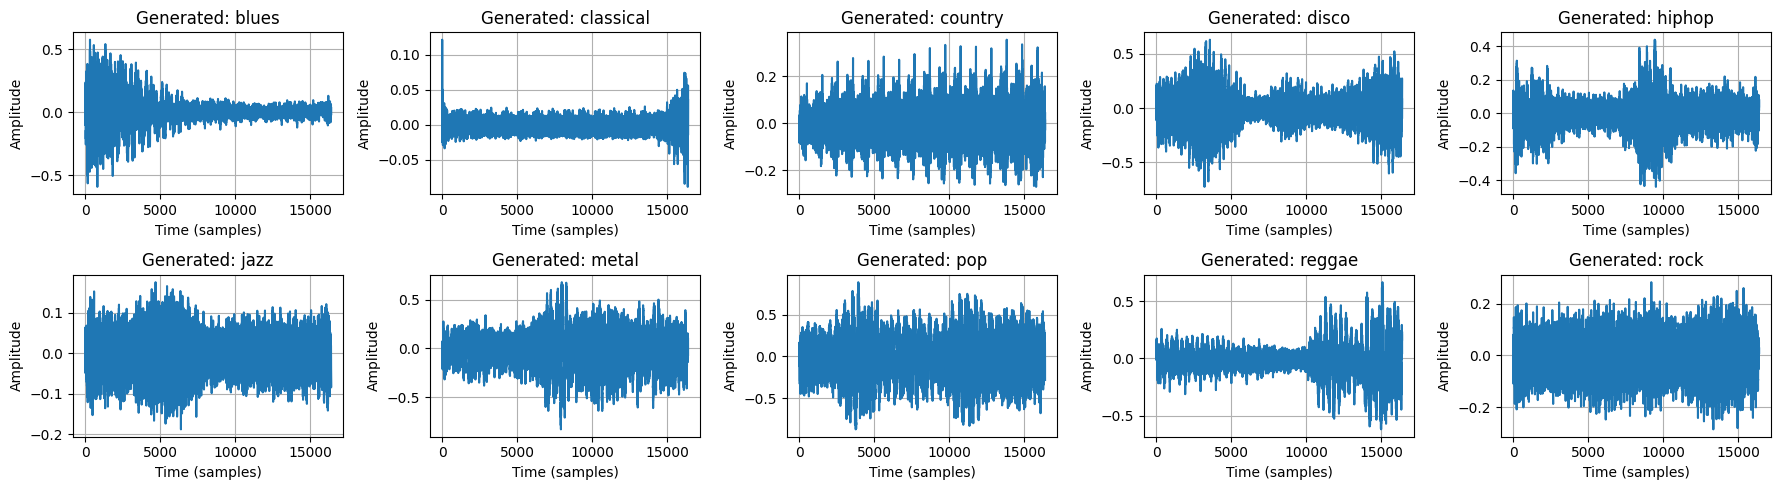

In [63]:
import matplotlib.pyplot as plt
import torch

def get_label_name(label_id):
    inv_mapping = {v: k for k, v in full_dataset.label_mapping.items()}
    return inv_mapping[label_id]

for G in generators:
    G.eval()

plt.figure(figsize=(18, 5))

for genre_idx in range(num_genres):
    G = generators[genre_idx]
    z = torch.randn(1, 100).to(device)
    with torch.no_grad():
        fake_waveform = G(z).squeeze().cpu().numpy()
        
    plt.subplot(2, 5, genre_idx + 1)
    plt.plot(fake_waveform)
    plt.title(f"Generated: {get_label_name(genre_idx)}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()
plt.show()

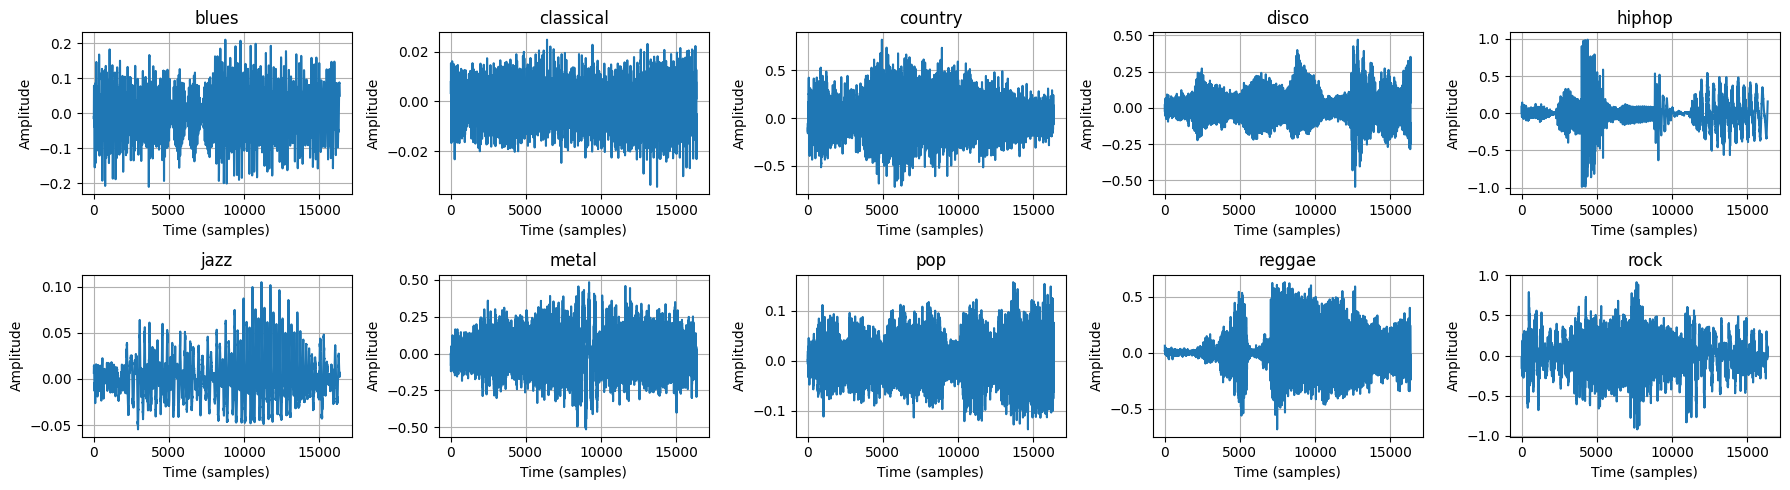

In [62]:
import matplotlib.pyplot as plt

class_names = list(full_dataset.label_mapping.keys())

shown = set()

plt.figure(figsize=(18, 5))
i = 0

for waveform, label in full_dataset:
    if label not in shown:
        waveform = waveform.squeeze().numpy()
        plt.subplot(2, 5, i + 1)
        plt.plot(waveform)
        plt.title(get_label_name(label))
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        shown.add(label)
        i += 1
    if len(shown) == len(class_names):
        break

plt.tight_layout()
plt.show()

In [48]:
fake_waveforms.shape

torch.Size([5, 1, 16384])

In [98]:
def generate_fake_samples(generators, num_samples_per_genre, device, target_sample_rate=22050):
    """
    Function to generate fake samples (MFCCs) using the provided generator models.

    Args:
        generators (list): A list of generator models (one for each genre).
        num_samples_per_genre (int): The number of fake samples to generate for each genre.
        device (torch.device): The device (CPU or GPU) to run the computations on.
        target_sample_rate (int, optional): The sample rate to resample the generated waveforms. Defaults to 22050 Hz.

    Returns:
        list: A list of tuples containing generated MFCCs and their respective genre index.
    """
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=target_sample_rate,
        n_mfcc=40,
        melkwargs={"n_fft": 900, "hop_length": 160, "n_mels": 40}
    )

    generated_data = []  # List to store generated MFCCs and their genre labels

    # Loop through each generator (one for each genre)
    for genre_idx, G in enumerate(generators):
        G.eval()
        
        # Generate the specified number of fake samples for this genre
        for _ in range(num_samples_per_genre):
            # Sample random noise vector (latent vector)
            z = torch.randn(1, 100).to(device)
            
            # Disable gradient calculation during the forward pass (as we don't need gradients for generation)
            with torch.no_grad():
                fake_waveform = G(z).squeeze(0).cpu()  # Generate fake waveform (remove unnecessary dimensions)

                # Ensure that the waveform has the correct shape (1, N) -> (N)
                if fake_waveform.dim() == 1:
                    fake_waveform = fake_waveform.unsqueeze(0)  # Add batch dimension if it's missing

                # Convert the generated waveform to MFCC features
                mfcc = mfcc_transform(fake_waveform)  # Output shape: (1, n_mfcc, time)

                # Squeeze the batch dimension and transpose the MFCC for correct shape (time, n_mfcc)
                mfcc = mfcc.squeeze(0)  # Shape becomes (n_mfcc, time)
                mfcc = mfcc.transpose(0, 1)  # Final shape: (time, n_mfcc)

                # Append the generated MFCCs and the genre index to the generated_data list
                generated_data.append((mfcc, genre_idx))
    
    return generated_data


In [105]:
from torch.utils.data import ConcatDataset

num_fake_samples_per_genre = len(gen_train) // 10

fake_samples = generate_fake_samples(generators, num_fake_samples_per_genre, device)

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

fake_dataset = SimpleDataset(fake_samples)
augmented_train = ConcatDataset([gen_train, fake_dataset])

In [106]:
for i in range(5):
    mfcc, label = augmented_train[i]
    print(f"Sample {i}: MFCC shape = {mfcc.shape}, Label = {label}")

len(augmented_train), len(gen_train), len(fake_dataset)

Sample 0: MFCC shape = torch.Size([103, 40]), Label = 5
Sample 1: MFCC shape = torch.Size([103, 40]), Label = 4
Sample 2: MFCC shape = torch.Size([103, 40]), Label = 8
Sample 3: MFCC shape = torch.Size([103, 40]), Label = 2
Sample 4: MFCC shape = torch.Size([103, 40]), Label = 3


(55960, 27980, 27980)

In [113]:
gen_train_loader = DataLoader(augmented_train, batch_size=128, shuffle=True, drop_last=True)
gen_val_loader   = DataLoader(gen_val, batch_size=128, drop_last=True)
gen_test_loader  = DataLoader(gen_test, batch_size=128, drop_last=True)

In [133]:
import torch.optim as optim
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# torch.backends.cudnn.enabled = False
torch.cuda.empty_cache()

model_6 = Net5().to(device)
model_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_6.parameters(), lr=0.0001)

print("\nTRAINING FOR 5 EPOCHS\n")
train_model(100, model_6, optimizer, gen_train_loader, gen_val_loader)


TRAINING FOR 5 EPOCHS

Epoch 1/100, Loss: 1.0392, Accuracy: 0.6856, Val_loss: 1.3633, Val_acc: 0.5174
Epoch 2/100, Loss: 0.6264, Accuracy: 0.7802, Val_loss: 1.1848, Val_acc: 0.5834
Epoch 3/100, Loss: 0.5363, Accuracy: 0.8114, Val_loss: 1.0530, Val_acc: 0.6309
Epoch 4/100, Loss: 0.4690, Accuracy: 0.8375, Val_loss: 0.9830, Val_acc: 0.6570
Epoch 5/100, Loss: 0.4087, Accuracy: 0.8583, Val_loss: 0.8780, Val_acc: 0.7025
Epoch 6/100, Loss: 0.3529, Accuracy: 0.8782, Val_loss: 0.8063, Val_acc: 0.7204
Epoch 7/100, Loss: 0.3056, Accuracy: 0.8951, Val_loss: 0.7370, Val_acc: 0.7457
Epoch 8/100, Loss: 0.2616, Accuracy: 0.9100, Val_loss: 0.6749, Val_acc: 0.7704
Epoch 9/100, Loss: 0.2212, Accuracy: 0.9252, Val_loss: 0.6744, Val_acc: 0.7737
Epoch 10/100, Loss: 0.1909, Accuracy: 0.9348, Val_loss: 0.6728, Val_acc: 0.7784
Epoch 11/100, Loss: 0.1562, Accuracy: 0.9474, Val_loss: 0.6074, Val_acc: 0.8007
Epoch 12/100, Loss: 0.1341, Accuracy: 0.9541, Val_loss: 0.5988, Val_acc: 0.8090
Epoch 13/100, Loss: 0.110

Result of Net6 for 50 epochs:
Test_loss: 0.6608734130859375, Test_accuracy: 0.829133064516129


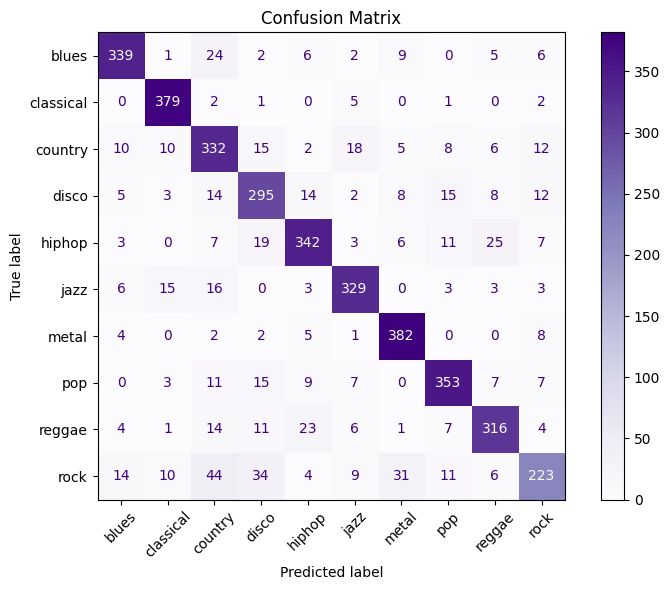

In [134]:
print("Result of Net6 for 50 epochs:")
test_model(model_6, gen_test_loader, full_dataset)